In [1]:
import pandas as pd
import numpy as np
import read_roi
import os
import re
import matplotlib
import seaborn
import matplotlib.pyplot as plt

In [2]:
figdir='/home/mt/figures/figures/image_counting/'

In [3]:
headpath='/media/mt/FreeRealEstate/MacaqueMotorCortex4/'
dirs=os.listdir(headpath)

FileNotFoundError: [Errno 2] No such file or directory: '/media/mt/FreeRealEstate/MacaqueMotorCortex4/'

In [ ]:
csvfiles=[]
roifiles=[]
for root, dirs, files in os.walk(headpath):
    #print(root,dirs,files)
    stitchy=[x for x in files if 'merged.stitchy' in x]
    for f in files:
        if 'mask_stats.csv' in f:
            csvfiles.append([root,root.split('/')[-3],f,stitchy[0]])
        if 'RoiSet.zip' in f:
            roifiles.append([root,root.split('/')[-3],f,stitchy[0]])
            

In [ ]:
roifiles=pd.DataFrame(roifiles)
csvfiles=pd.DataFrame(csvfiles)

In [ ]:
count_table=[]
for l in csvfiles.index:
    print(csvfiles.loc[l,0])
    print(csvfiles.loc[l,2])
    stitchy=re.sub('_merged\.stitchy','',csvfiles.loc[l,3])
    stitchy=list(reversed(stitchy.split('_')))
    stitchy=[x for x in stitchy if not re.search('hoechst',x,re.IGNORECASE)]
    df=pd.read_csv(os.path.join(csvfiles.loc[l,0],csvfiles.loc[l,2]))
    #print(stitchy)
    #print(df)
    df[' ']=stitchy
    df_wide=pd.wide_to_long(df,['Area','Mean','Min','Max'],i=' ',j='cell')
    df_wide.reset_index(inplace=True)
    roidict=read_roi.read_roi_zip(re.sub('mask_stats.csv','RoiSet.zip',os.path.join(csvfiles.loc[l,0],csvfiles.loc[l,2])))
    name=[]
    x=[]
    y=[]
    realval=[]
    for k in roidict.keys():
        name.append(k)
        try:
            x.append(np.mean(roidict[k]['x']))
            y.append(np.mean(roidict[k]['y']))
            realval.append(True)
        except:
            pass
            realval.append(False)
    x=np.repeat(x,df.shape[0])
    y=np.repeat(y,df.shape[0])
    realval=np.repeat(realval,df.shape[0])
    name=np.repeat(name,df.shape[0])
    df_wide['x']=np.nan
    df_wide['y']=np.nan
    df_wide['roiname']=name
    df_wide.loc[realval,'x']=-x
    df_wide.loc[realval,'y']=-y
    df_wide=df_wide.loc[realval,:]
    df_wide['file']=csvfiles.loc[l,1]
    df_wide['fullname']=re.sub('_mask_stats.csv','',csvfiles.loc[l,2])
    df_wide['section']=re.search('_TR[0-9]_[0-9]+',csvfiles.loc[l,1])[0].split('_')[2]
    df_wide['region']=csvfiles.loc[l,2].split('_')[0]
    df_wide['gene']=df_wide[' ']
    df_wide.index=df_wide['roiname']
    df_wide['supervised']='nan'
    try:
        print(re.sub('_mask_stats.csv','_RoiSet_supervision.txt',os.path.join(csvfiles.loc[l,0],csvfiles.loc[l,2])))
        supervisedf=pd.read_csv(re.sub('_mask_stats.csv','_RoiSet_supervision.txt',os.path.join(csvfiles.loc[l,0],csvfiles.loc[l,2])),header=None,index_col=0)
        supervisedf=supervisedf.loc[~supervisedf.index.duplicated(keep='last'),:]
        supervisedf=supervisedf.loc[supervisedf.index.isin(df_wide.index),:]
        df_wide.loc[supervisedf.index,'supervised']=supervisedf[1]
        print(supervisedf)
    except Exception as e: 
        print(e)
    count_table.append(df_wide)
    #count_table.append([csvfiles.loc[l,1],re.sub('_mask_stats.csv','',csvfiles.loc[l,2]),re.search('_TR[0-9]_[0-9]+',csvfiles.loc[l,1])[0].split('_')[2],csvfiles.loc[l,2].split('_')[0],df_wide])
    

In [4]:
count_table

NameError: name 'count_table' is not defined

In [19]:
count_table=pd.concat(count_table)

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [21]:
#number of cells counted manually
count_table.loc[count_table['supervised']!='nan',:].shape[0]

11388

In [22]:
count_table['supervised'].unique()

array(['nan', 'Neither', 'TAC3', 'Div TAC3', 'MAF', 'Div MAF', 'Both',
       'TAC3 LHX8', 'LHX8', 'Div Both'], dtype=object)

In [23]:
count_table.loc[count_table['supervised'].str.contains('Neither'),'supervised']='MAF'

In [24]:
count_table.loc[count_table['supervised']=='Both','supervised']='TAC3'

In [25]:
count_table['section']=count_table['section'].astype(int)

In [26]:
count_table.loc[count_table['section']>400,'section']=300

In [27]:
count_table['section']=-count_table['section']+count_table['section'].max()

In [28]:
count_table

,,cell,Area,Mean,Min,Max,x,y,roiname,file,fullname,section,region,gene,supervised
roiname,,,,,,,,,,,,,,,
00004-07218-06603,TAC3,1,234,27.543,0.0,93.0,-6602.642857,-7218.607143,00004-07218-06603,E65-2019A_TR1_225_20210607,GE_CRABP1,133,GE,TAC3,nan
00004-07218-06603,MKI67,1,234,41.415,0.0,167.0,-6602.642857,-7218.607143,00004-07218-06603,E65-2019A_TR1_225_20210607,GE_CRABP1,133,GE,MKI67,nan
00004-07218-06603,ETV1,1,234,56.697,11.0,156.0,-6602.642857,-7218.607143,00004-07218-06603,E65-2019A_TR1_225_20210607,GE_CRABP1,133,GE,ETV1,nan
00004-07218-06603,CRABP1,1,234,254.000,254.0,254.0,-6602.642857,-7218.607143,00004-07218-06603,E65-2019A_TR1_225_20210607,GE_CRABP1,133,GE,CRABP1,nan
00004-07253-06997,TAC3,2,68,13.029,0.0,35.0,-6996.500000,-7253.400000,00004-07253-06997,E65-2019A_TR1_225_20210607,GE_CRABP1,133,GE,TAC3,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
00003-10955-12658,RBP4,4881,186,30.387,11.0,45.0,-12658.814815,-10955.444444,00003-10955-12658,E65_271_TR1_20210507,Striatum_CRABP1,58,Striatum,RBP4,nan
00003-10955-12658,ANGPT2,4881,186,254.000,254.0,254.0,-12658.814815,-10955.444444,00003-10955-12658,E65_271_TR1_20210507,Striatum_CRABP1,58,Striatum,ANGPT2,nan
00003-11015-12483,STXBP6,4883,114,43.061,22.0,67.0,-12483.535714,-11015.428571,00003-11015-12483,E65_271_TR1_20210507,Striatum_CRABP1,58,Striatum,STXBP6,nan


[]

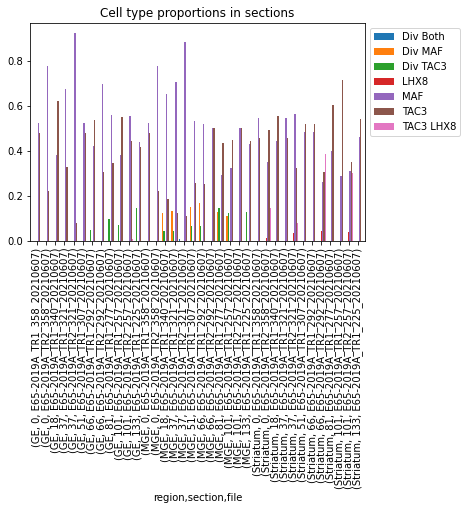

In [29]:
ax=count_table.loc[count_table['supervised']!='nan',:].groupby(['region','section','file'])['supervised'].value_counts(normalize=True).unstack().plot(kind='bar', width=1)
ax.set_title("Cell type proportions in sections",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot(figsize=(13,13))

In [30]:
colordict={'MAF':'blue', 'TAC3':'magenta','Neither':'gray','Div MAF':'cyan','Div TAC3':'hotpink','Div Both':'white','LHX8':'goldenrod','TAC3 LHX8':'maroon','nan':'white'}

In [31]:
df_plot=pd.DataFrame(count_table.loc[count_table['supervised']!='nan',:].groupby(['region','file','section'])['supervised'].value_counts(normalize=True)['GE']).unstack(fill_value=0).stack().sort_values('section')#.plot(x='section',y='',kind='scatter')

In [32]:
df_plot.columns=['Mean Proportion']

In [33]:
df_plot=df_plot.reset_index()

In [34]:
df_plot=df_plot.reset_index()
df_plot['section']=df_plot['section'].astype(int)

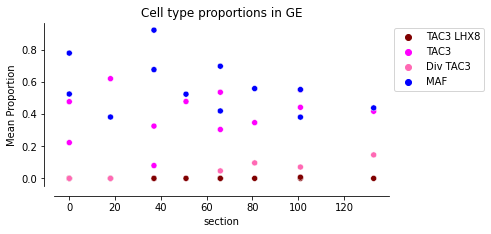

In [35]:
fig, ax = plt.subplots(figsize=(6,3))
seaborn.scatterplot(x='section',y='Mean Proportion',hue='supervised',data=df_plot,palette=colordict, ci='sd',ax=ax)
seaborn.despine(offset=10)
ax.set_title("Cell type proportions in GE",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot(figsize=(1,1))
plt.savefig(os.path.join(figdir,'GE_TAC3_proportions.pdf'))
df_plot

In [76]:
df_plot=pd.DataFrame(count_table.loc[count_table['supervised']!='nan',:].groupby(['region','file','section'])['supervised'].value_counts(normalize=True)['Striatum']).unstack(fill_value=0).stack().sort_values('section')#.plot(x='section',y='',kind='scatter')


In [77]:
df_plot.columns=['Mean Proportion']

In [78]:
df_plot=df_plot.reset_index()
df_plot['section']=df_plot['section'].astype(int)

In [79]:
df_plot=df_plot.loc[~(df_plot['supervised'].isin(['TAC3 LHX8']) & ~df_plot['file'].isin(['E65-2019A_TR2_257_20210607','E65-2019A_TR2_292_20210607','E65-2019A_TR2_321_20210607','E65-2019A_TR2_358_20210607'])),:]
df_plot=df_plot.loc[~(df_plot['supervised'].str.contains('Div') & df_plot['file'].isin(['E65-2019A_TR2_257_20210607','E65-2019A_TR2_292_20210607','E65-2019A_TR2_321_20210607','E65-2019A_TR2_358_20210607'])),:]


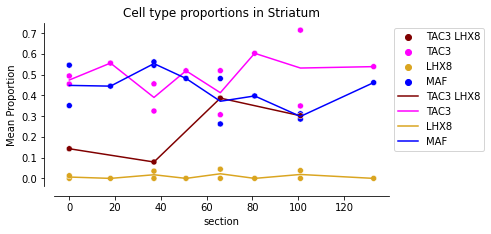

In [80]:
fig, ax = plt.subplots(figsize=(6,3))
seaborn.scatterplot(x='section',y='Mean Proportion',hue='supervised',data=df_plot,palette=colordict,ax=ax)
seaborn.lineplot(x='section',y='Mean Proportion',hue='supervised',data=df_plot,palette=colordict,ax=ax,ci=None)
seaborn.despine(offset=10)
ax.set_title("Cell type proportions in Striatum",color='black')
ax.legend(bbox_to_anchor=(1, 1))
plt.savefig(os.path.join(figdir,'Striatum_TAC3_proportions.svg'))

In [81]:
df_plot=pd.DataFrame(count_table.loc[count_table['supervised']!='nan',:].groupby(['region','file','section'])['supervised'].value_counts(normalize=True)['MGE']).unstack(fill_value=0).stack().sort_values('section')#.plot(x='section',y='',kind='scatter')

In [82]:
df_plot.columns=['Mean Proportion']

In [83]:
df_plot=df_plot.reset_index()

In [84]:
df_plot=df_plot.reset_index()
df_plot['section']=df_plot['section'].astype(int)

In [85]:
df_plot.loc[df_plot['Mean Proportion']==0,:]

,index,file,section,supervised,Mean Proportion
2,2,E65-2019A_TR1_358_20210607,0,Div Both,0.0
3,3,E65-2019A_TR1_358_20210607,0,Div MAF,0.0
6,6,E65-2019A_TR1_358_20210607,0,Div TAC3,0.0
7,7,E65-2019A_TR2_358_20210607,0,Div TAC3,0.0
8,8,E65-2019A_TR2_358_20210607,0,Div Both,0.0
9,9,E65-2019A_TR2_358_20210607,0,Div MAF,0.0
11,11,E65-2019A_TR1_340_20210607,18,Div Both,0.0
17,17,E65-2019A_TR2_321_20210607,37,Div MAF,0.0
22,22,E65-2019A_TR2_321_20210607,37,Div TAC3,0.0
23,23,E65-2019A_TR1_321_20210607,37,Div Both,0.0


In [86]:
df_plot=df_plot.loc[~(df_plot['supervised'].isin(['TAC3 LHX8']) & ~df_plot['file'].isin(['E65-2019A_TR2_257_20210607','E65-2019A_TR2_292_20210607','E65-2019A_TR2_321_20210607','E65-2019A_TR2_358_20210607'])),:]
df_plot=df_plot.loc[~(df_plot['supervised'].str.contains('Div') & df_plot['file'].isin(['E65-2019A_TR2_257_20210607','E65-2019A_TR2_292_20210607','E65-2019A_TR2_321_20210607','E65-2019A_TR2_358_20210607'])),:]


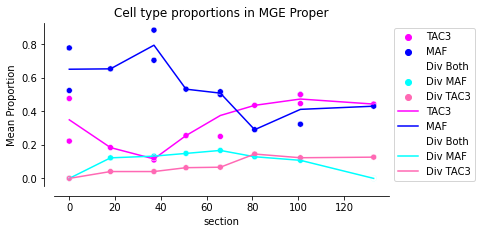

In [87]:
fig, ax = plt.subplots(figsize=(6,3))
seaborn.scatterplot(x='section',y='Mean Proportion',hue='supervised',data=df_plot,palette=colordict,ax=ax)
seaborn.lineplot(x='section',y='Mean Proportion',hue='supervised',data=df_plot,palette=colordict,ax=ax,ci=None)
seaborn.despine(offset=10)
ax.set_title("Cell type proportions in MGE Proper",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot(figsize=(1,1))
plt.savefig(os.path.join(figdir,'MGE_TAC3_proportions.svg'))

In [88]:
count_table.loc[count_table['supervised']!='nan',:].groupby(['region','section'])['supervised'].value_counts(normalize=True)

region    section  supervised
GE        0        MAF           0.684211
                   TAC3          0.315789
          18       TAC3          0.619048
                   MAF           0.380952
          37       MAF           0.821053
                                   ...   
Striatum  101      MAF           0.300546
                   TAC3 LHX8     0.174863
                   LHX8          0.021858
          133      TAC3          0.538462
                   MAF           0.461538
Name: supervised, Length: 75, dtype: float64

## Blue is GE, Orange is striatum

['TAC3' 'MKI67' 'ETV1' 'CRABP1']


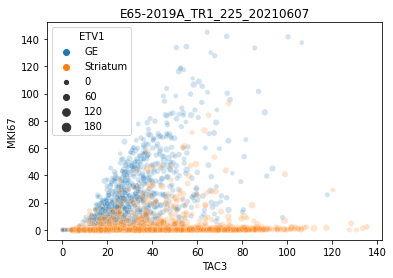

['TAC3' 'MKI67' 'ETV1' 'CRABP1']


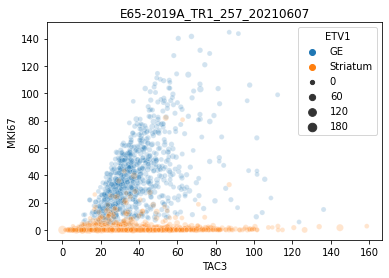

['TAC3' 'MKI67' 'ETV1' 'CRABP1']


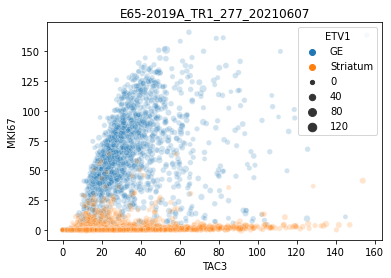

['TAC3' 'MKI67' 'ETV1' 'CRABP1']


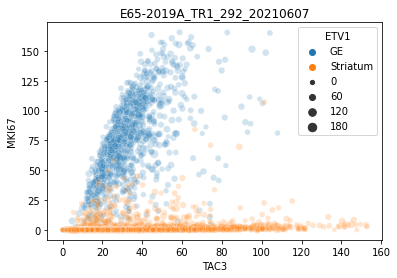

['TAC3' 'MKI67' 'ETV1' 'CRABP1']


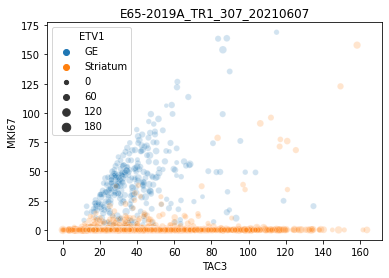

['TAC3' 'MKI67' 'ETV1' 'CRABP1']


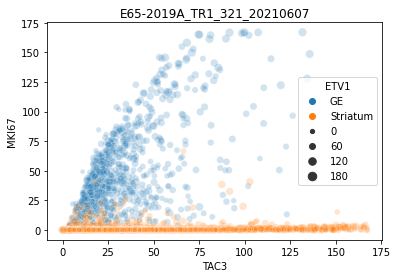

['TAC3' 'MKI67' 'ETV1' 'CRABP1']


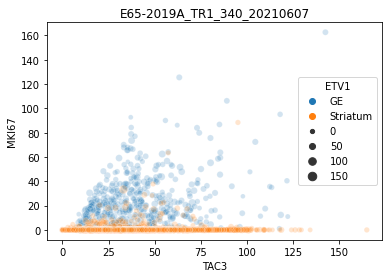

['TAC3' 'MKI67' 'ETV1' 'CRABP1']


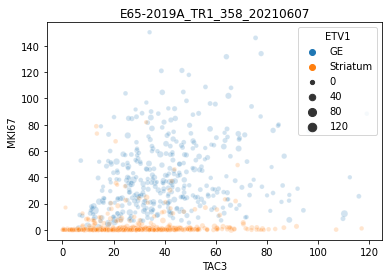

['TAC3' 'MAF' 'LHX8' 'CRABP1']


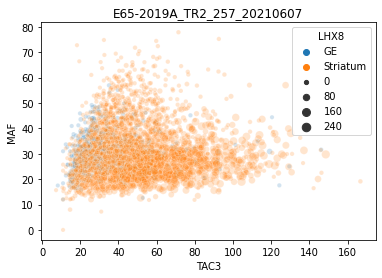

['TAC3' 'MAF' 'LHX8' 'CRABP1']


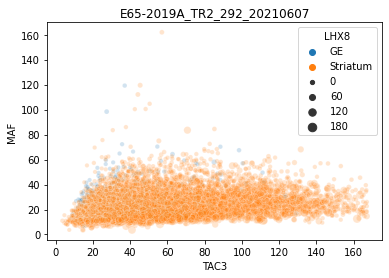

['TAC3' 'MAF' 'LHX8' 'CRABP1']


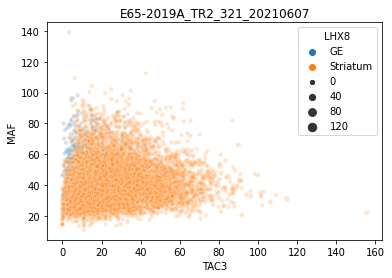

['TAC3' 'MAF' 'LHX8' 'CRABP1']


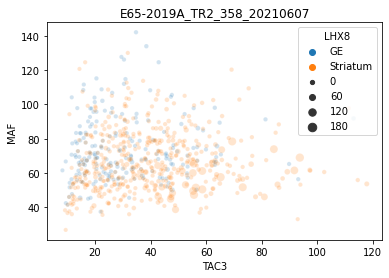

['STXBP6' 'RBP4' 'ANGPT2']


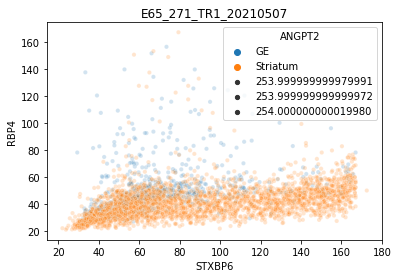

In [487]:
last=''
for x in count_table['file'].unique():
    curdf=count_table.loc[count_table['file']==x,:]
    genes=curdf['gene'].unique()
    print(genes)
    x1=curdf.loc[curdf['gene']==genes[0],'Mean'].to_list()
    x2=curdf.loc[curdf['gene']==genes[1],'Mean'].to_list()
    x3=curdf.loc[curdf['gene']==genes[2],'Mean'].to_list()
    x4=curdf.loc[curdf['gene']==genes[0],'region'].to_list()
    seaborn.scatterplot(x=x1,y=x2,size=x3,hue=x4,alpha=.2)
    plt.xlabel(genes[0])
    plt.ylabel(genes[1])
    plt.legend(title=genes[2])
    plt.title(x)
    plt.show()
    #if last == current:
    #    plt.show()
    #last=current
plt.show()


## Expression values of CRABP1 cells transposed into RGBs

E65-2019A_TR1_225_20210607


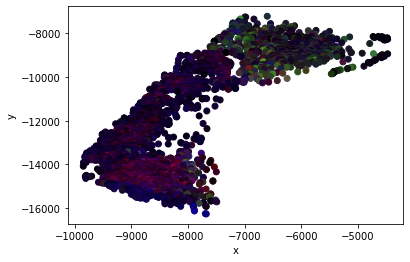

(r,g,b) ['TAC3' 'MKI67' 'ETV1' 'CRABP1']


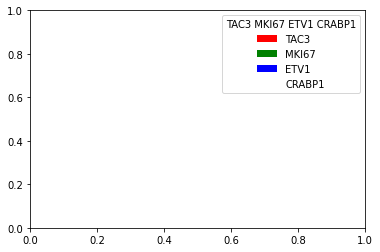

E65-2019A_TR1_257_20210607


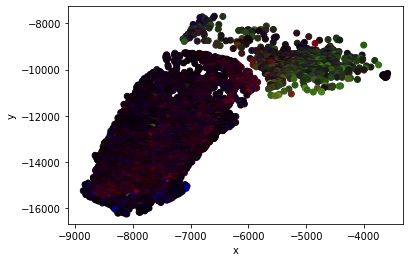

(r,g,b) ['TAC3' 'MKI67' 'ETV1' 'CRABP1']


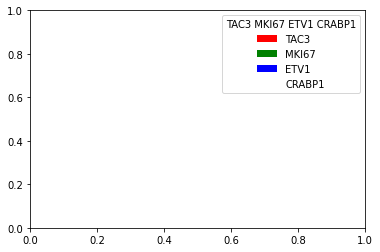

E65-2019A_TR1_277_20210607


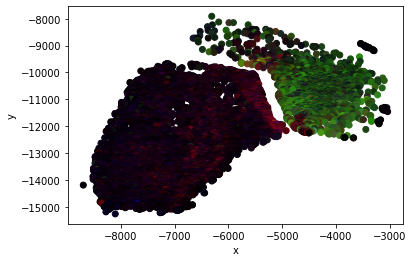

(r,g,b) ['TAC3' 'MKI67' 'ETV1' 'CRABP1']


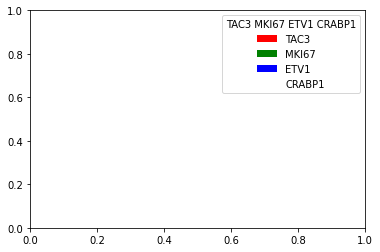

E65-2019A_TR1_292_20210607


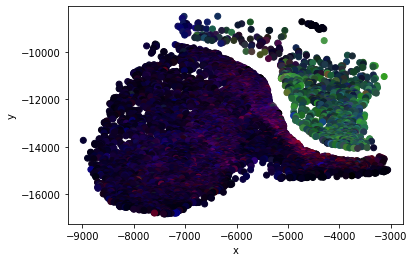

(r,g,b) ['TAC3' 'MKI67' 'ETV1' 'CRABP1']


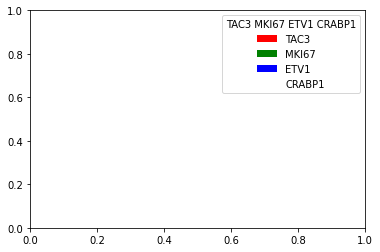

E65-2019A_TR1_307_20210607


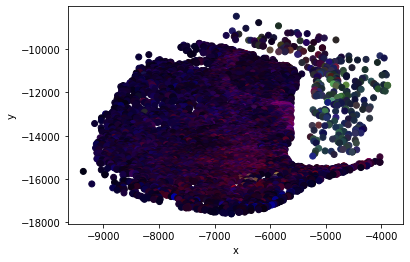

(r,g,b) ['TAC3' 'MKI67' 'ETV1' 'CRABP1']


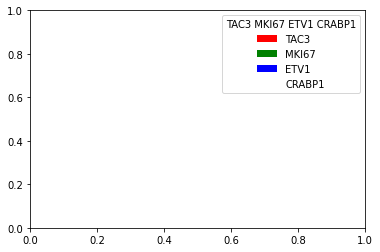

E65-2019A_TR1_321_20210607


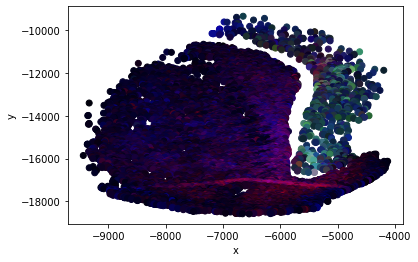

(r,g,b) ['TAC3' 'MKI67' 'ETV1' 'CRABP1']


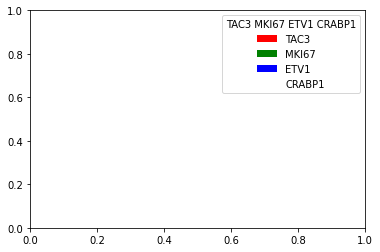

E65-2019A_TR1_340_20210607


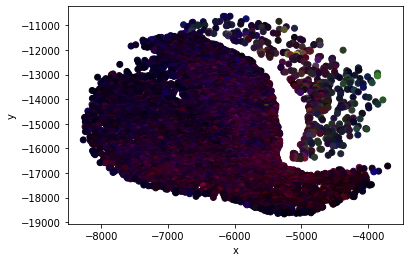

(r,g,b) ['TAC3' 'MKI67' 'ETV1' 'CRABP1']


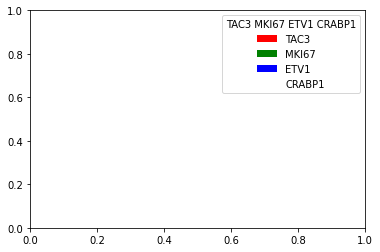

E65-2019A_TR1_358_20210607


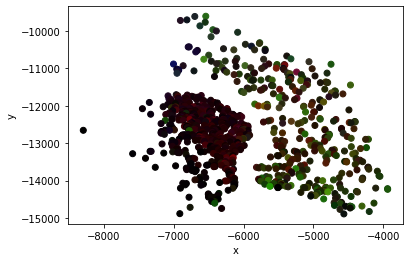

(r,g,b) ['TAC3' 'MKI67' 'ETV1' 'CRABP1']


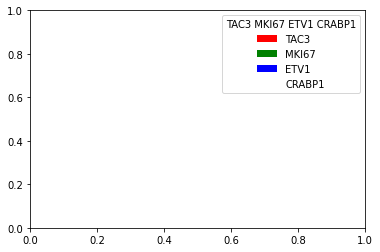

E65-2019A_TR2_257_20210607


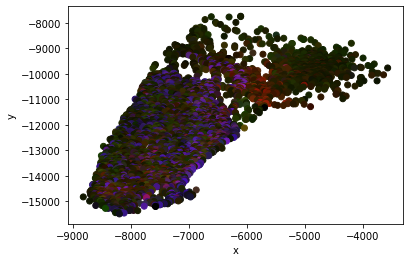

(r,g,b) ['TAC3' 'MAF' 'LHX8' 'CRABP1']


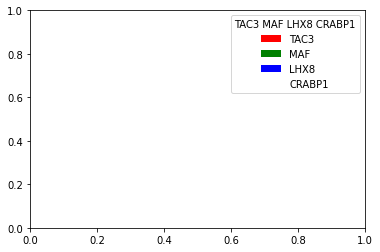

E65-2019A_TR2_292_20210607


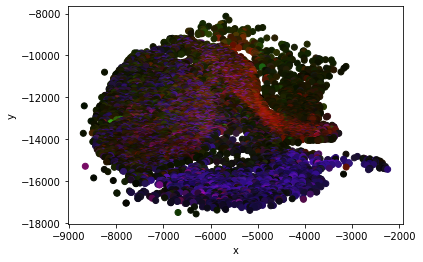

(r,g,b) ['TAC3' 'MAF' 'LHX8' 'CRABP1']


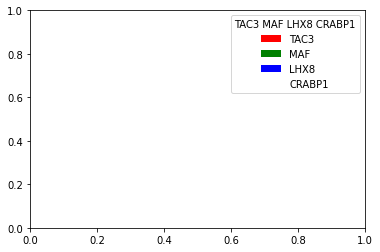

E65-2019A_TR2_321_20210607


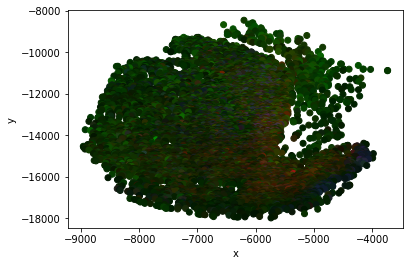

(r,g,b) ['TAC3' 'MAF' 'LHX8' 'CRABP1']


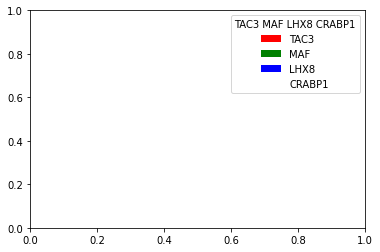

E65-2019A_TR2_358_20210607


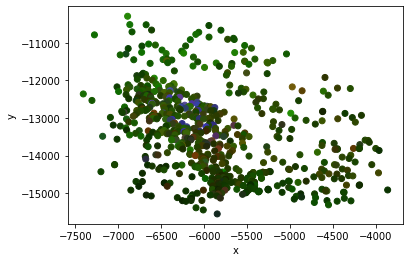

(r,g,b) ['TAC3' 'MAF' 'LHX8' 'CRABP1']


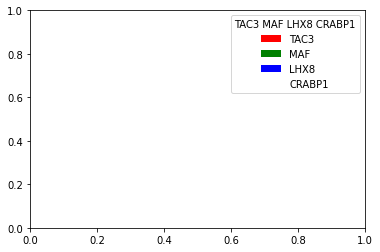

E65_271_TR1_20210507


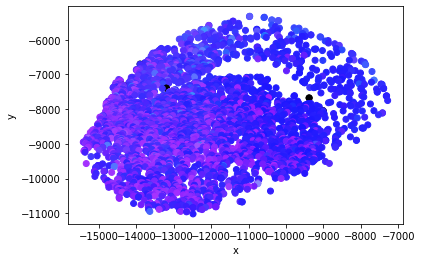

(r,g,b) ['STXBP6' 'RBP4' 'ANGPT2']


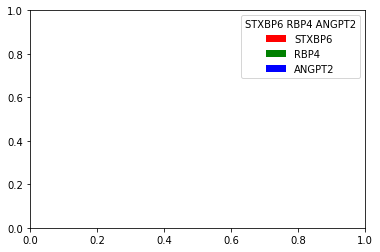

In [488]:
from matplotlib.patches import Patch
last=''
for x in count_table['file'].unique():
    print(x)
    curdf=count_table.loc[count_table['file']==x,:]
    genes=curdf['gene'].unique()
    x1=curdf.loc[curdf['gene']==genes[2],'x'].to_list()
    x2=curdf.loc[curdf['gene']==genes[1],'y'].to_list()
    x3=['#%02x%02x%02x' % (r,g,b) for r,g,b in zip(*[curdf.loc[curdf['gene']==genes[q],'Mean'].fillna(0).astype(int).to_list() for q in [0,1,2]])]
    plt.scatter(x=x1,y=x2,c=x3)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    plt.legend(handles=[Patch(facecolor=c,label=l) for c,l in zip(['red','green','blue','white'],genes)],title=' '.join(genes))
    print('(r,g,b)',genes)
    plt.show()
plt.show()

E65-2019A_TR1_225_20210607


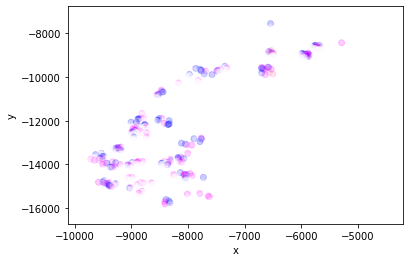

E65-2019A_TR1_257_20210607


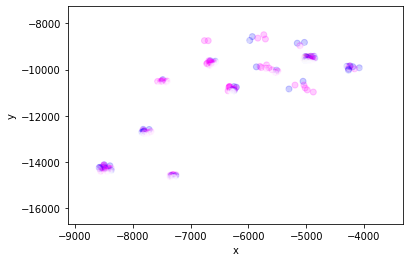

E65-2019A_TR1_277_20210607


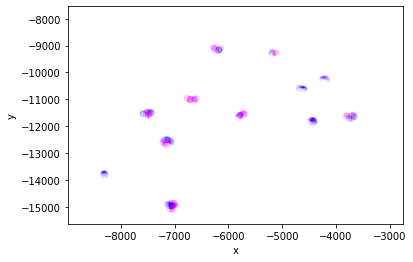

E65-2019A_TR1_292_20210607


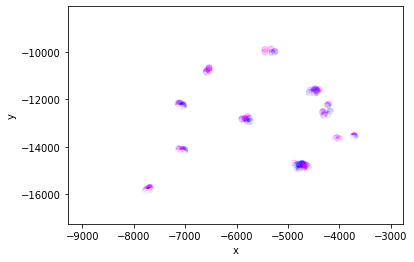

E65-2019A_TR1_307_20210607


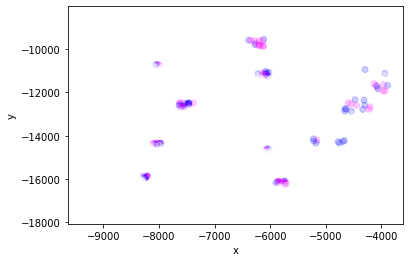

E65-2019A_TR1_321_20210607


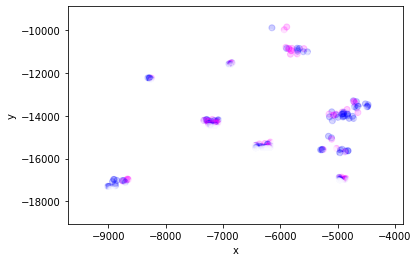

E65-2019A_TR1_340_20210607


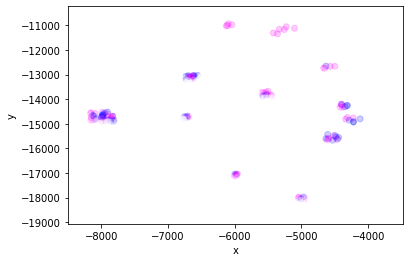

E65-2019A_TR1_358_20210607


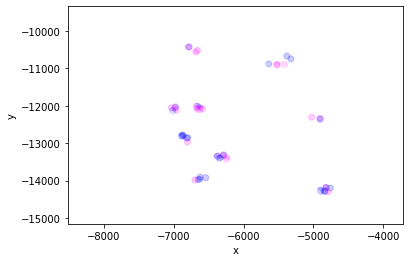

E65-2019A_TR2_257_20210607


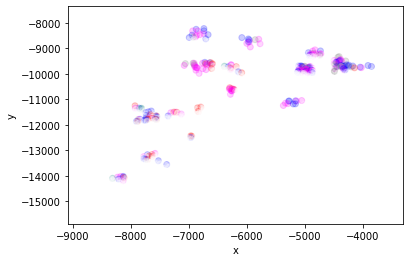

E65-2019A_TR2_292_20210607


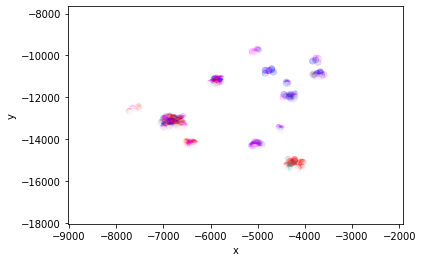

E65-2019A_TR2_321_20210607


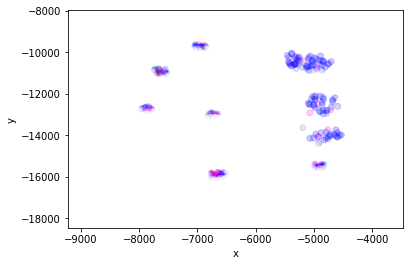

E65-2019A_TR2_358_20210607


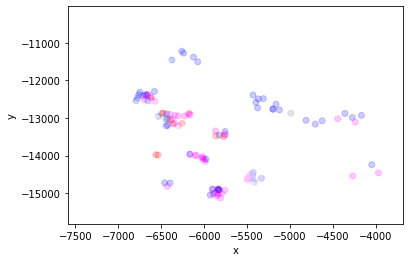

E65_271_TR1_20210507


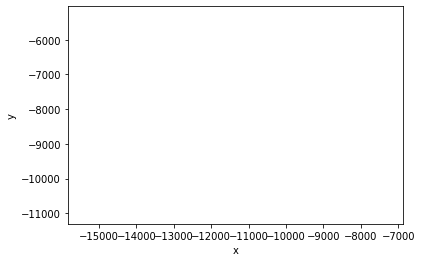

In [497]:
from matplotlib.patches import Patch
last=''
for x in count_table['file'].unique():
    print(x)
    curdf=count_table.loc[count_table['file']==x,:]
    genes=curdf['gene'].unique()
    x1=curdf.loc[curdf['gene']==genes[2],'x'].to_list()
    x2=curdf.loc[curdf['gene']==genes[1],'y'].to_list()
    x3=[colordict[x] for x in curdf.loc[curdf['gene']==genes[1],'supervised']]
    plt.scatter(x=x1,y=x2,c=x3,alpha=.2)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
plt.show()

In [66]:
import sklearn
import sklearn.mixture
sklearn.mixture.GaussianMixture()

GaussianMixture()

In [67]:
count_table

,,cell,Area,Mean,Min,Max,x,y,file,fullname,section,region,gene
0,TAC3,1,90,16.833,0.0,47.0,-7122.200000,-7131.200000,E65-2019A_TR1_225_20210607,GE_CRABP1,225,GE,TAC3
1,MKI67,1,90,10.889,0.0,56.0,-7122.200000,-7131.200000,E65-2019A_TR1_225_20210607,GE_CRABP1,225,GE,MKI67
2,ETV1,1,90,75.744,22.0,156.0,-7122.200000,-7131.200000,E65-2019A_TR1_225_20210607,GE_CRABP1,225,GE,ETV1
3,CRABP1,1,90,254.000,254.0,254.0,-7122.200000,-7131.200000,E65-2019A_TR1_225_20210607,GE_CRABP1,225,GE,CRABP1
4,TAC3,2,208,28.846,0.0,93.0,-6603.451613,-7219.225806,E65-2019A_TR1_225_20210607,GE_CRABP1,225,GE,TAC3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23437,RBP4,7813,186,30.387,11.0,45.0,-12658.814815,-10955.444444,E65_271_TR1_20210507,Test_ANGPT2,20210507,Test,RBP4
23438,ANGPT2,7813,186,254.000,254.0,254.0,-12658.814815,-10955.444444,E65_271_TR1_20210507,Test_ANGPT2,20210507,Test,ANGPT2
23442,STXBP6,7815,114,43.061,22.0,67.0,-12483.535714,-11015.428571,E65_271_TR1_20210507,Test_ANGPT2,20210507,Test,STXBP6
23443,RBP4,7815,114,28.974,22.0,56.0,-12483.535714,-11015.428571,E65_271_TR1_20210507,Test_ANGPT2,20210507,Test,RBP4


In [68]:
count_table.file.unique()

array(['E65-2019A_TR1_225_20210607', 'E65-2019A_TR1_257_20210607',
       'E65-2019A_TR1_277_20210607', 'E65-2019A_TR1_292_20210607',
       'E65-2019A_TR1_307_20210607', 'E65-2019A_TR1_321_20210607',
       'E65-2019A_TR1_340_20210607', 'E65-2019A_TR1_358_20210607',
       'E65-2019A_TR2_257_20210607', 'E65-2019A_TR2_292_20210607',
       'E65-2019A_TR2_321_20210607', 'E65-2019A_TR2_358_20210607',
       'E65_271_TR1_20210507'], dtype=object)

In [69]:
count_table.gene.unique()

array(['TAC3', 'MKI67', 'ETV1', 'CRABP1', 'MAF', 'LHX8', 'STXBP6', 'RBP4',
       'ANGPT2'], dtype=object)

In [70]:
count_table.region.unique()

array(['GE', 'Striatum', 'Test'], dtype=object)

In [71]:
means=count_table.groupby(['file','gene','region'])['Mean'].mean()
stds=count_table.groupby(['file','gene','region'])['Mean'].std()

In [78]:
last=''
for x in count_table['file'].unique():
    ind1=count_table['file']==x
    genes=count_table['gene'][ind1].unique()
    print(genes)
    for g in genes:
        ind2=(count_table['gene']==g) & ind1
        if 'Striatum' in means[x][g].index:
            print((count_table.loc[ind2,'Mean']-means[x][g]['Striatum'])/stds[x][g]['Striatum'])
            print(count_table.loc[ind2,:])
            count_table.loc[ind2,'Mean']=(count_table.loc[ind2,'Mean']-means[x][g]['Striatum'])/stds[x][g]['Striatum']

['TAC3' 'MKI67' 'ETV1' 'CRABP1']
0      -1.009680
4      -0.446556
8      -0.944476
12     -0.574481
16     -0.981039
          ...   
4912   -1.160200
4916   -1.252124
4920   -0.275927
4924   -1.248187
4928   -1.565961
Name: Mean, Length: 1643, dtype: float64
            cell  Area    Mean  Min    Max            x             y  \
0     TAC3     1    90  16.833  0.0   47.0 -7122.200000  -7131.200000   
4     TAC3     2   208  28.846  0.0   93.0 -6603.451613  -7219.225806   
8     TAC3     3   116  18.224  0.0   35.0 -6838.625000  -7348.375000   
12    TAC3     4   120  26.117  0.0   58.0 -7291.529412  -7370.411765   
16    TAC3     5    81  17.444  0.0   47.0 -7003.647059  -7472.352941   
...    ...   ...   ...     ...  ...    ...          ...           ...   
4912  TAC3  1229   238  13.622  0.0   47.0 -9353.344828 -16327.413793   
4916  TAC3  1230   165  11.661  0.0   35.0 -9221.875000 -16460.812500   
4920  TAC3  1231   175  32.486  0.0  151.0 -9190.375000 -16490.437500   
4924  TAC

TAC3


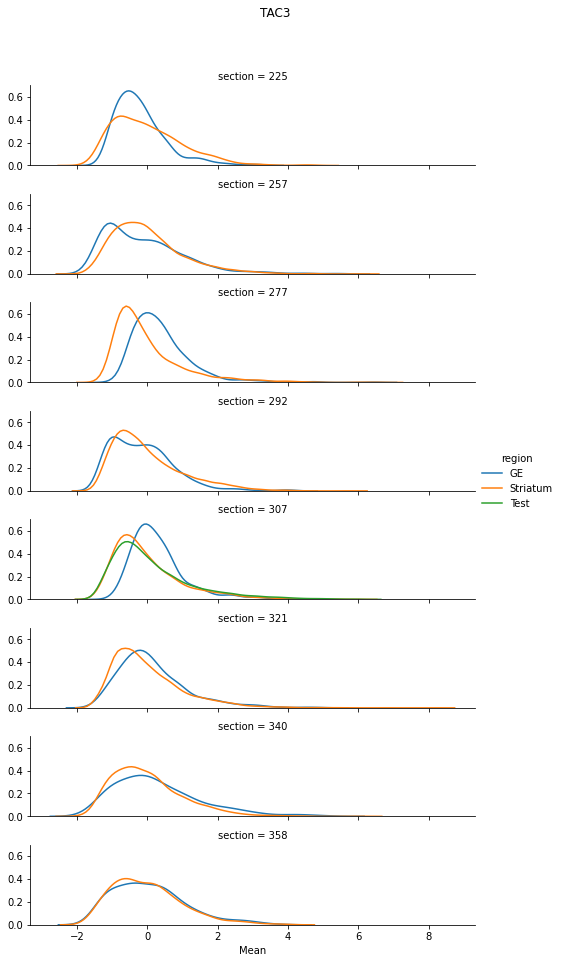

MKI67


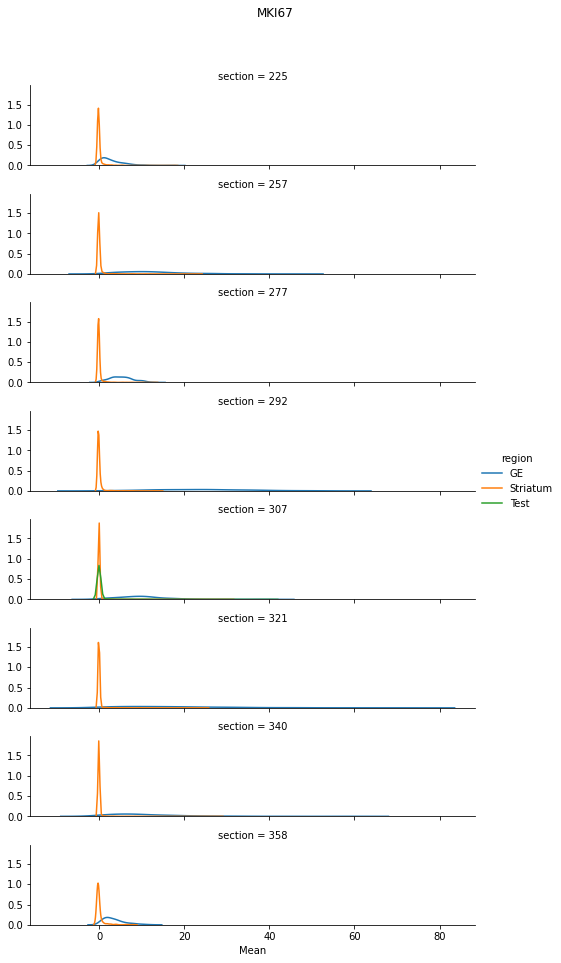

ETV1


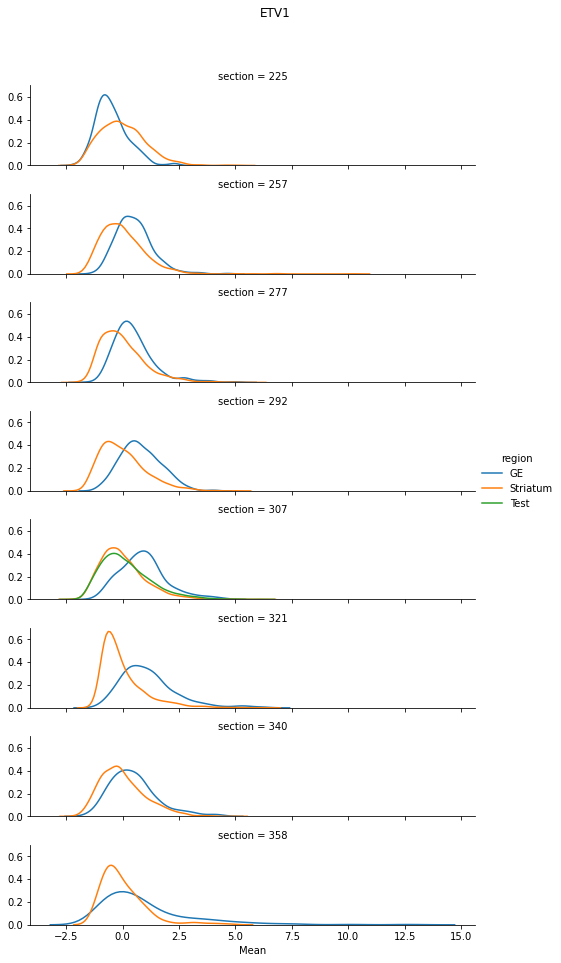

CRABP1


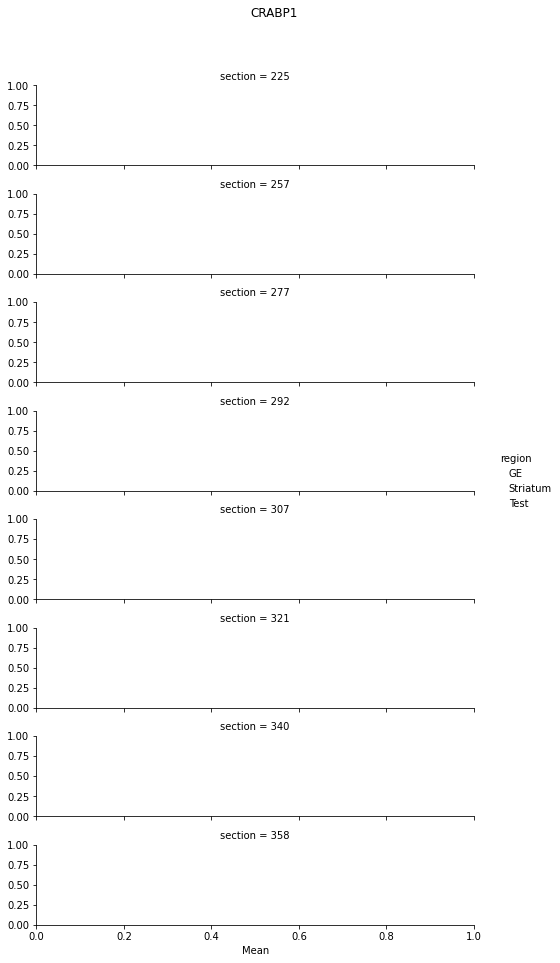

MAF


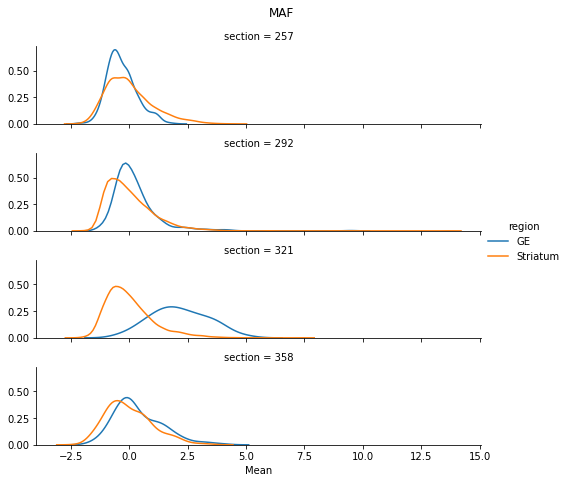

LHX8


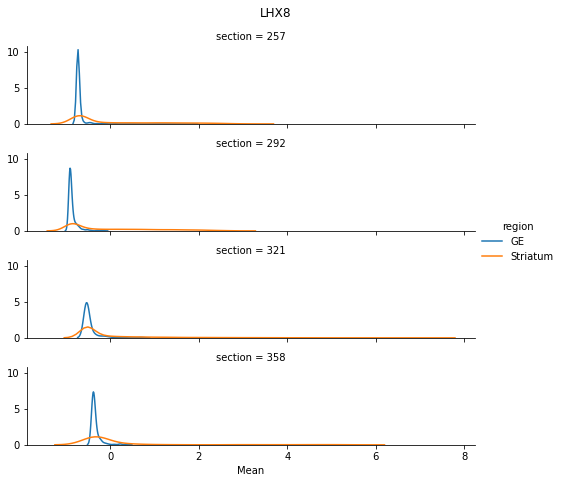

STXBP6


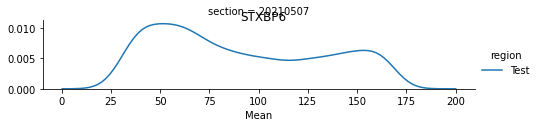

RBP4


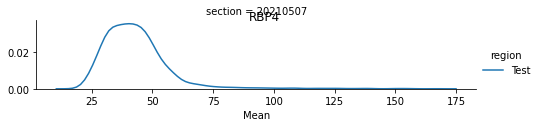

ANGPT2


/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


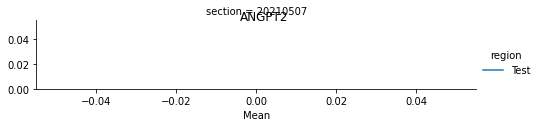

In [90]:
last=''

genes=count_table['gene'].unique()
for gene in genes:
    ind1=(count_table['gene']==gene)
    #for x in count_table['file'].unique():
    #    ind2=ind1 & (count_table['file']==x)    
        #for r in count_table['region'].unique():
        #    ind3=ind2&(count_table['region']==r)
        #    seaborn.distplot(count_table.loc[ind3,'Mean'],label=r)
    print(gene)
    g = seaborn.FacetGrid(count_table.loc[ind1,:], row="section",
            height=1.7, aspect=4,hue='region')
    g.map(seaborn.kdeplot, "Mean")
    g.add_legend()
    g.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
    g.fig.suptitle(gene)
    plt.show()
        
        


TAC3
['GE' 'Striatum']


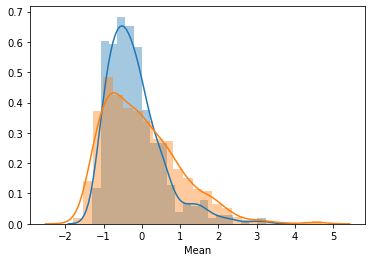

MKI67
['GE' 'Striatum']


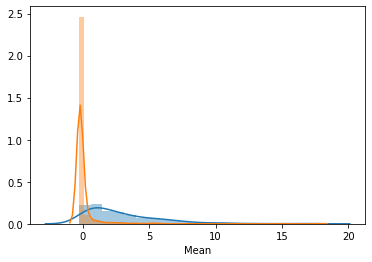

ETV1
['GE' 'Striatum']


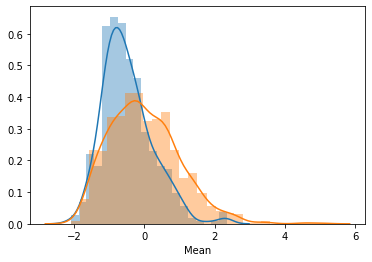

CRABP1
['GE' 'Striatum']


/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


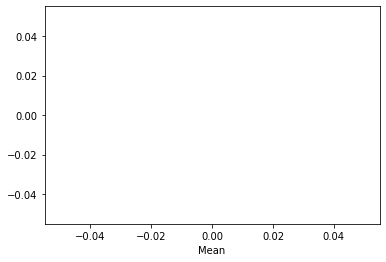

TAC3
['GE' 'Striatum']


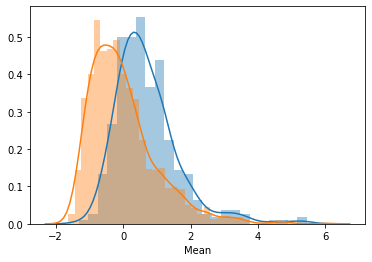

MKI67
['GE' 'Striatum']


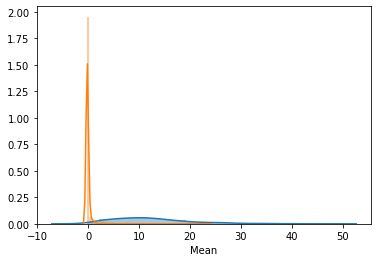

ETV1
['GE' 'Striatum']


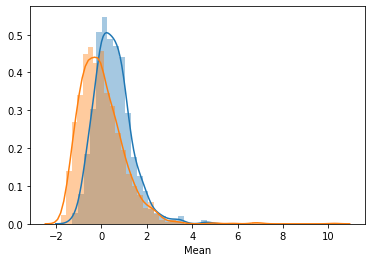

CRABP1
['GE' 'Striatum']


/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


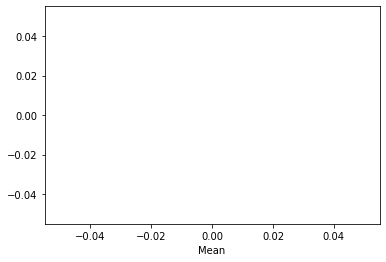

TAC3
['GE' 'Striatum']


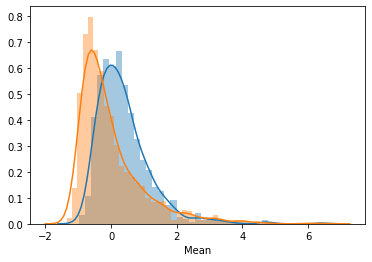

MKI67
['GE' 'Striatum']


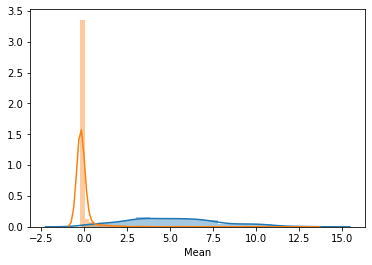

ETV1
['GE' 'Striatum']


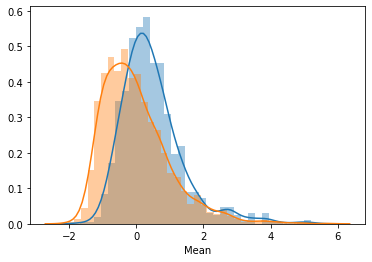

CRABP1
['GE' 'Striatum']


/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


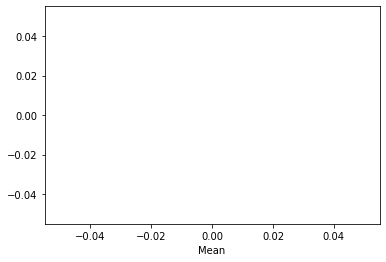

TAC3
['GE' 'Striatum']


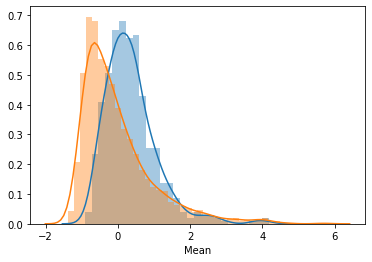

MKI67
['GE' 'Striatum']


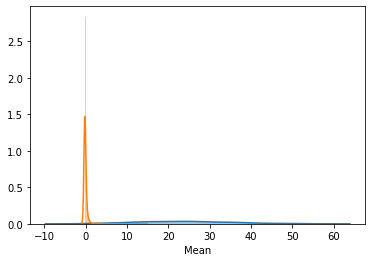

ETV1
['GE' 'Striatum']


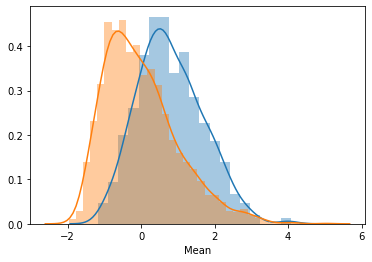

CRABP1
['GE' 'Striatum']


/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


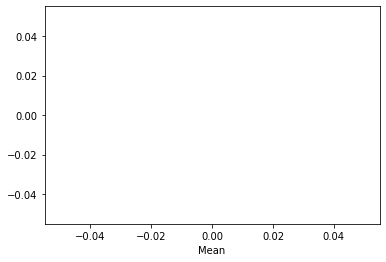

TAC3
['GE' 'Striatum' 'Test']


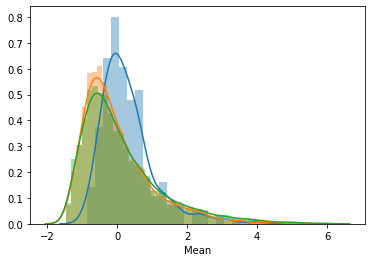

MKI67
['GE' 'Striatum' 'Test']


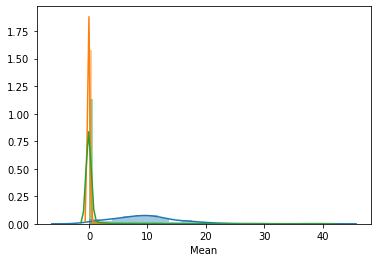

ETV1
['GE' 'Striatum' 'Test']


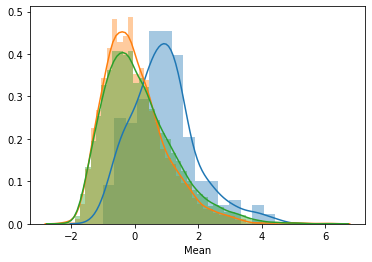

CRABP1
['GE' 'Striatum' 'Test']


/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


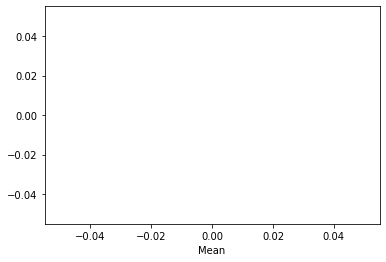

TAC3
['GE' 'Striatum']


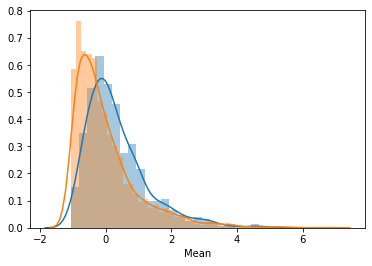

MKI67
['GE' 'Striatum']


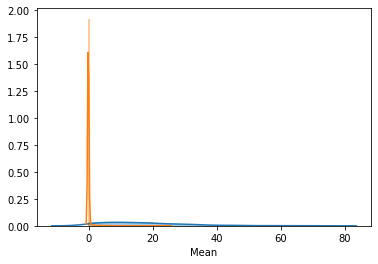

ETV1
['GE' 'Striatum']


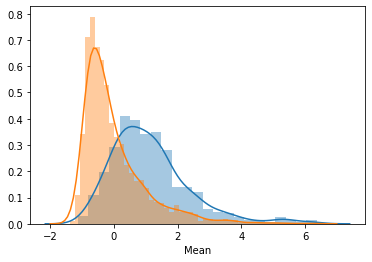

CRABP1
['GE' 'Striatum']


/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


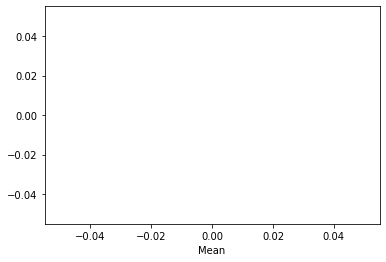

TAC3
['GE' 'Striatum']


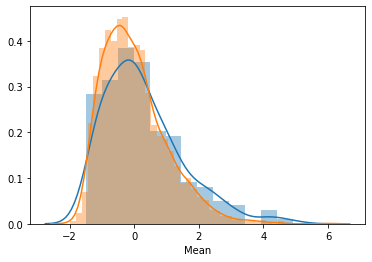

MKI67
['GE' 'Striatum']


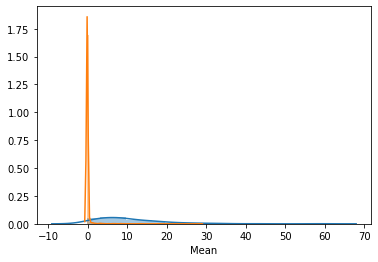

ETV1
['GE' 'Striatum']


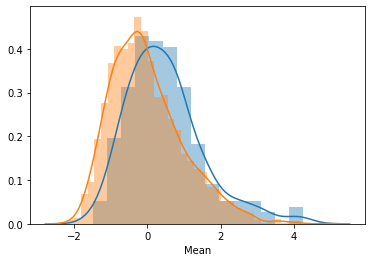

CRABP1
['GE' 'Striatum']


/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


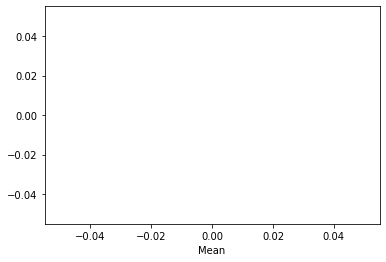

TAC3
['GE' 'Striatum']


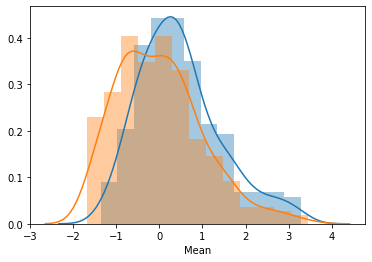

MKI67
['GE' 'Striatum']


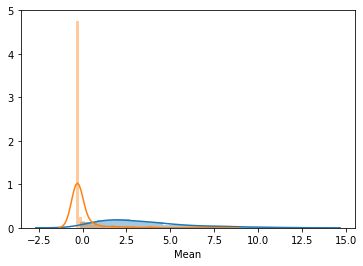

ETV1
['GE' 'Striatum']


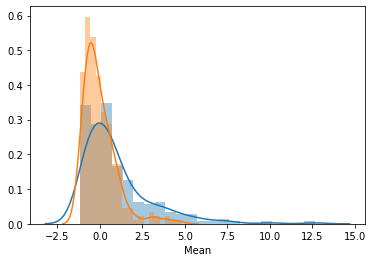

CRABP1
['GE' 'Striatum']


/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


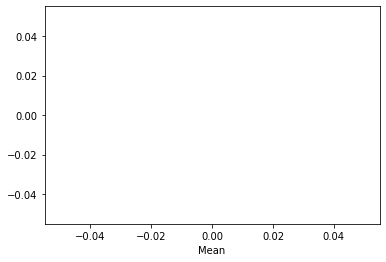

TAC3
['GE' 'Striatum']


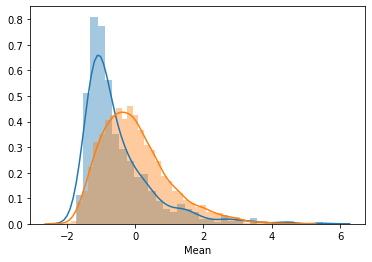

MAF
['GE' 'Striatum']


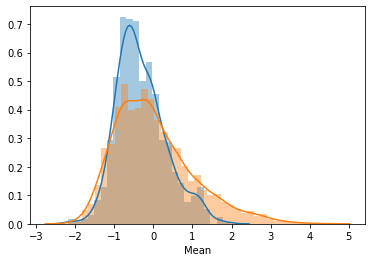

LHX8
['GE' 'Striatum']


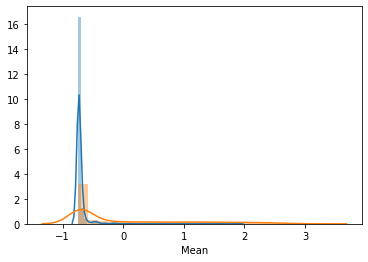

CRABP1
['GE' 'Striatum']


/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


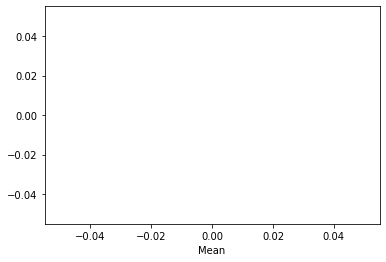

TAC3
['GE' 'Striatum']


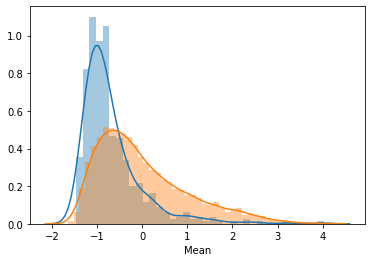

MAF
['GE' 'Striatum']


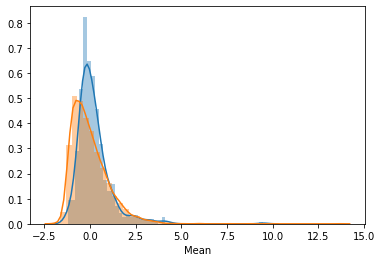

LHX8
['GE' 'Striatum']


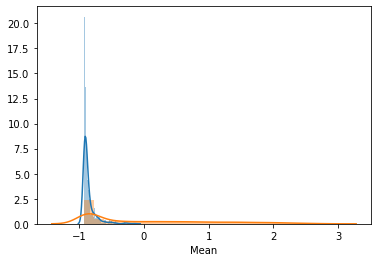

CRABP1
['GE' 'Striatum']


/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


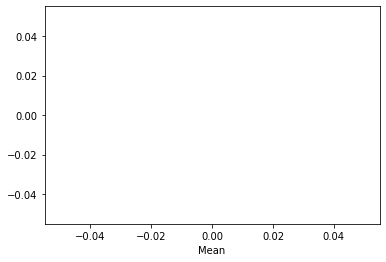

TAC3
['GE' 'Striatum']


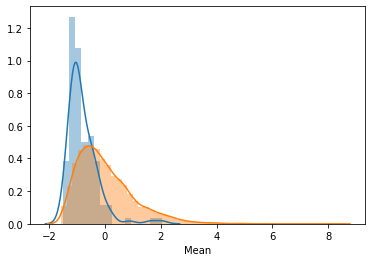

MAF
['GE' 'Striatum']


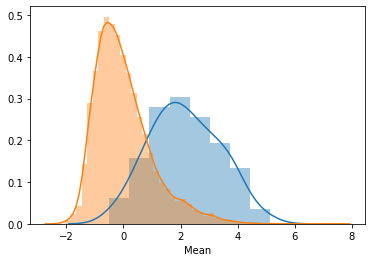

LHX8
['GE' 'Striatum']


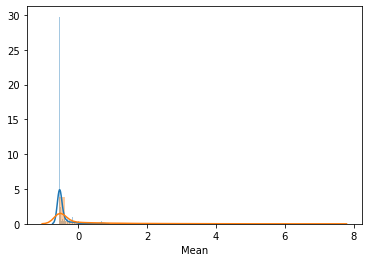

CRABP1
['GE' 'Striatum']


/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


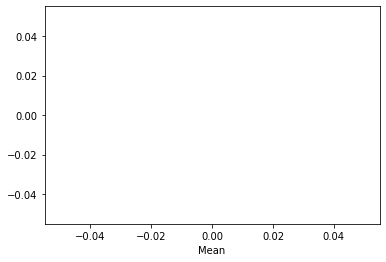

TAC3
['GE' 'Striatum']


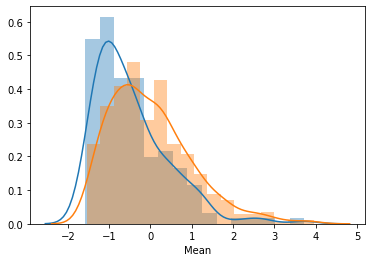

MAF
['GE' 'Striatum']


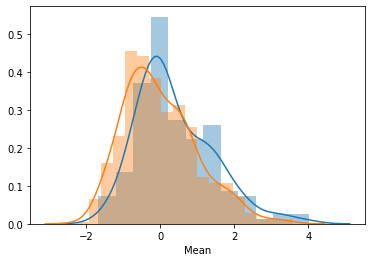

LHX8
['GE' 'Striatum']


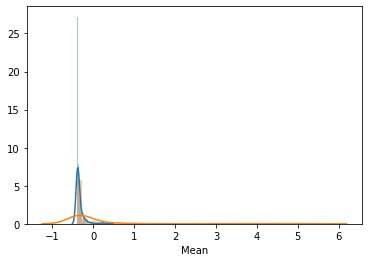

CRABP1
['GE' 'Striatum']


/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


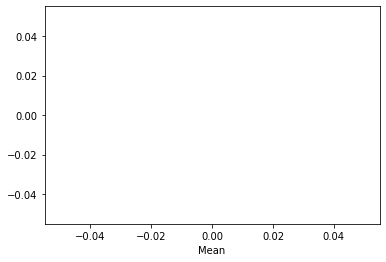

STXBP6
['Test']


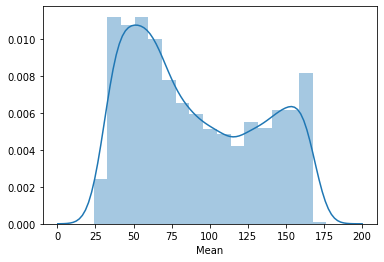

RBP4
['Test']


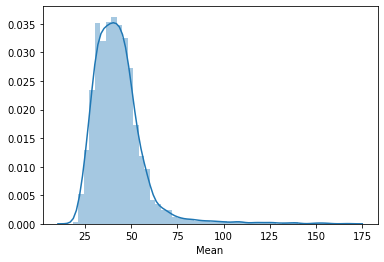

ANGPT2
['Test']


/home/mt/anaconda3/envs/imaging/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


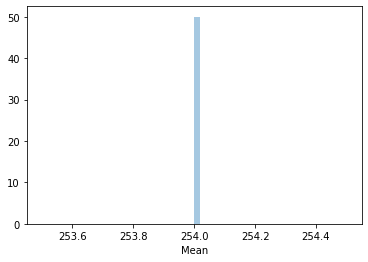

In [79]:
last=''
for x in count_table['file'].unique():
    curdf=count_table.loc[count_table['file']==x,:]
    genes=curdf['gene'].unique()
    for g in genes:
        print(g)
        gdf=curdf.loc[curdf['gene']==g,:]
        print(gdf['region'].unique())
        for r in gdf['region'].unique():
            seaborn.distplot(gdf.loc[gdf['region']==r,'Mean'],label=r)
        plt.show()
        
plt.show()


In [10]:
last=''
for g in [0,1,2]:
    for i in count_table:
        print(i[2],i[3])
        genes=i[4][' '].unique()
        if any(['MKI67' in x for x in genes]):
            current=i[2]
            x1=i[4].loc[i[4][' ']==genes[g],'x'].to_list()
            x2=i[4].loc[i[4][' ']==genes[g],'y'].to_list()
            x3=i[4].loc[i[4][' ']==genes[g],'Mean'].to_list()
            seaborn.scatterplot(x=x1,y=x2,hue=x3)
            plt.xlabel('x')
            plt.ylabel('y')
            plt.legend(title=genes[g])
            plt.title(i[2])
            print(last,current)
            if last == current:
                plt.show()
            last=current

IndexError: string index out of range